In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import os

from dask.distributed import Client

# import xgcm
# print("xgcm version", xgcm.__version__)

import cosima_cookbook as cc
from cosima_cookbook import explore

import matplotlib.pyplot as plt
import cmocean as cm
import cf_xarray
import cftime
import cartopy.crs as ccrs

import xmovie
from xmovie import Movie
print("xmovie version", xmovie.__version__)

import warnings
warnings.filterwarnings(
    action="ignore",
    category=UserWarning,
    message=r"No `(vmin|vmax)` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `\1` to avoid this step"
)

map_path = "/g/data/ik11/grids/BlueMarble.tiff"
blue_marble = plt.imread(map_path)
blue_marble_extent = (-180, 180, -90, 90)

%matplotlib inline

xmovie version 0.3.1


In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 48,Total memory: 188.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36069,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 188.56 GiB
Comm: tcp://127.0.0.1:45481,Total threads: 6
Dashboard: /proxy/35479/status,Memory: 23.57 GiB
Nanny: tcp://127.0.0.1:41171,


2024-12-17 09:59:06,972 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('transpose-243d27bcec1ebbfd671ccb1a25eed051', 9, 0, 1, 1) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: waiting
old run_spec: Alias(('transpose-243d27bcec1ebbfd671ccb1a25eed051', 9, 0, 1, 1)->('concatenate-groupby_nanmean-simple-reduce-aggregate-transpose-243d27bcec1ebbfd671ccb1a25eed051', 9, 0, 1, 1))
new run_spec: Alias(('transpose-243d27bcec1ebbfd671ccb1a25eed051', 9, 0, 1, 1)->('concatenate-transpose-243d27bcec1ebbfd671ccb1a25eed051', 9, 0, 1, 1))
old token: ('Alias', ('transpose-243d27bcec1ebbfd671ccb1a25eed051', 9, 0, 1, 1), ('concatenate-gr

In [3]:
session = cc.database.create_session()

In [4]:
# dbx = explore.DatabaseExplorer(session=session)
# dbx

In [5]:
# ee = explore.ExperimentExplorer(session=session, experiment='01deg_jra55v140_iaf')
# ee

In [6]:
minlon = -235
maxlon = -140
midlon = (minlon + maxlon) / 2

minlat = -5
maxlat = +5
midlat = (minlat + maxlat) / 2

start_time = "1958-01-01 12:00:00"
end_time = "2018-12-31 12:00:00"
time_slice = slice(start_time, end_time)
climatology_baseline = slice("2000", None)

depth_slice = slice(0, 500)
lat_slice = slice(minlat, maxlat)
lon_slice = slice(minlon, maxlon)

In [7]:
resolution = "0.10" # "0.25" (for quicker) or "0.10" (for higher resolution, state of the art)

def load_variable(resolution, varname, start_time, end_time, depth_slice, lat_slice, lon_slice):

    if resolution == "0.25":
        experiment = "025deg_jra55_iaf_omip2_cycle6"
    elif resolution == "0.10":
        experiment = "01deg_jra55v140_iaf_cycle4"
    else:
        experiment = None

    var = cc.querying.getvar(expt=experiment, variable=varname,
                             session=session, frequency='1 monthly',
                             attrs={'cell_methods': 'time: mean'},
                             start_time=start_time, 
                             end_time=end_time,
                             chunks={})

    time_slice = slice(start_time, end_time)

    if lat_slice != None:
        var = var.cf.sel(latitude=lat_slice)

    if lon_slice != None:
        var = var.cf.sel(longitude=lon_slice)
        
    if depth_slice != None:
        var = var.cf.sel(vertical=depth_slice)

    return var

In [8]:
temp = load_variable(resolution, "temp", start_time, end_time, depth_slice, lat_slice, lon_slice)
temp

<xarray.DataArray 'temp' (time: 732, st_ocean: 39, yt_ocean: 100, xt_ocean: 950)> Size: 11GB
dask.array<getitem, shape=(732, 39, 100, 950), dtype=float32, chunksize=(1, 19, 80, 180), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 8kB -234.9 -234.8 -234.7 ... -140.2 -140.1
  * yt_ocean  (yt_ocean) float64 800B -4.944 -4.844 -4.745 ... 4.745 4.844 4.944
  * st_ocean  (st_ocean) float64 312B 0.5413 1.681 2.94 ... 383.0 423.7 468.4
  * time      (time) datetime64[ns] 6kB 1958-01-16T12:00:00 ... 2018-12-16T12...
Attributes:
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_conservative_temperature
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2022-04-27
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...

Compute the nino34 index; just for sanity:

In [9]:
sst = temp.cf.sel(vertical=0, method="nearest")
nino34_region = sst.cf.sel(latitude=slice(-5, 5), longitude=slice(-170, -120))
climatology = nino34_region.cf.sel(time=climatology_baseline).groupby('time.month').mean(dim='time')
sst_anomaly = nino34_region.groupby('time.month') - climatology
nino34_index = sst_anomaly.cf.mean(dim=['latitude', 'longitude'])
nino34_index = nino34_index.rename("nino34")
nino34_index.persist()
nino34_index

<xarray.DataArray 'nino34' (time: 732)> Size: 3kB
dask.array<mean_agg-aggregate, shape=(732,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  (time) float64 6kB 0.5413 0.5413 0.5413 ... 0.5413 0.5413 0.5413
  * time      (time) datetime64[ns] 6kB 1958-01-16T12:00:00 ... 2018-12-16T12...
    month     (time) int64 6kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12

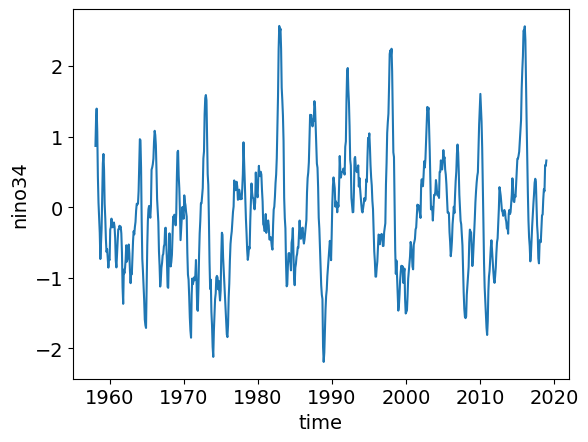

In [10]:
nino34_index.plot()

Compute anomaly based on climatology over `climatology_baseline` period.

In [11]:
temp_climatology = temp.cf.sel(time=climatology_baseline).groupby('time.month').mean(dim='time')
temp_anomaly = temp.groupby("time.month") - temp_climatology
temp_anomaly = temp_anomaly.rename("temp_anomaly")
temp_anomaly.persist()

<xarray.DataArray 'temp_anomaly' (time: 732, st_ocean: 39, yt_ocean: 100,
                                  xt_ocean: 950)> Size: 11GB
dask.array<sub, shape=(732, 39, 100, 950), dtype=float32, chunksize=(1, 19, 80, 180), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 8kB -234.9 -234.8 -234.7 ... -140.2 -140.1
  * yt_ocean  (yt_ocean) float64 800B -4.944 -4.844 -4.745 ... 4.745 4.844 4.944
  * st_ocean  (st_ocean) float64 312B 0.5413 1.681 2.94 ... 383.0 423.7 468.4
  * time      (time) datetime64[ns] 6kB 1958-01-16T12:00:00 ... 2018-12-16T12...
    month     (time) int64 6kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12

Average over the latitude range

In [12]:
temp_anomaly = temp_anomaly.cf.mean("latitude")
temp_anomaly

<xarray.DataArray 'temp_anomaly' (time: 732, st_ocean: 39, xt_ocean: 950)> Size: 108MB
dask.array<mean_agg-aggregate, shape=(732, 39, 950), dtype=float32, chunksize=(1, 19, 180), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 8kB -234.9 -234.8 -234.7 ... -140.2 -140.1
  * st_ocean  (st_ocean) float64 312B 0.5413 1.681 2.94 ... 383.0 423.7 468.4
  * time      (time) datetime64[ns] 6kB 1958-01-16T12:00:00 ... 2018-12-16T12...
    month     (time) int64 6kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12

Save as netCDF for quicker load!

In [13]:
filename = "temp_anomaly-" + resolution.replace(".", "p")

if os.path.exists(filename + ".nc"):
    print("The file " + filename + ".nc" + " already exists.")
else:
    print("The file " + filename + ".nc" + " does not exist. Saving it now...")
    temp_anomaly.to_netcdf(filename + ".nc")

The file temp_anomaly-0p10.nc does not exist. Saving it now...


Load the anomaly from the netCDF file!

In [14]:
temp_anomaly = xr.open_dataarray(filename + ".nc")
temp_anomaly

<xarray.DataArray 'temp_anomaly' (time: 732, st_ocean: 39, xt_ocean: 950)> Size: 108MB
[27120600 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 8kB -234.9 -234.8 -234.7 ... -140.2 -140.1
  * st_ocean  (st_ocean) float64 312B 0.5413 1.681 2.94 ... 383.0 423.7 468.4
  * time      (time) datetime64[ns] 6kB 1958-01-16T12:00:00 ... 2018-12-16T12...
    month     (time) int64 6kB ...

In [15]:
def plot_temp(da, fig, timestamp, *args, **kwargs):

    ax = fig.add_subplot(1, 1, 1)

    da.isel(time=timestamp).plot(
        ax=ax,
        vmin=-3.5,
        vmax=+3.5,
        extend="both",
        cmap="RdBu_r",
        cbar_kwargs={"label": "temp anomaly (deg)",
                     "fraction": 0.03,
                     "aspect": 15,
                     "shrink": 0.7},
    )

    ax.set_title(da['time'].dt.strftime('%d-%m-%Y')[timestamp].item())

    ax.invert_yaxis()
    ax.set_ylabel("depth (m)")
    ax.set_xlabel("longitude (degE)")

    return ax, None

Plot a frame of the movie to check it out.

(<Axes: title={'center': '16-01-1958'}, xlabel='longitude (degE)', ylabel='depth (m)'>,
 None)

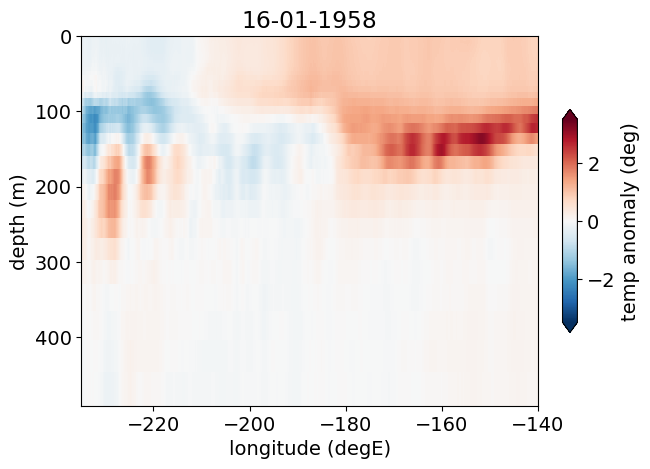

In [16]:
fig = plt.figure()

plot_temp(temp_anomaly, fig, 0)

Create a movie object! Chunk the data array to use `parallel=True` when saving the movie.

In [17]:
fig = plt.figure()

mov = Movie(temp_anomaly.chunk({'time': 1}), plot_temp);

<Figure size 640x480 with 0 Axes>

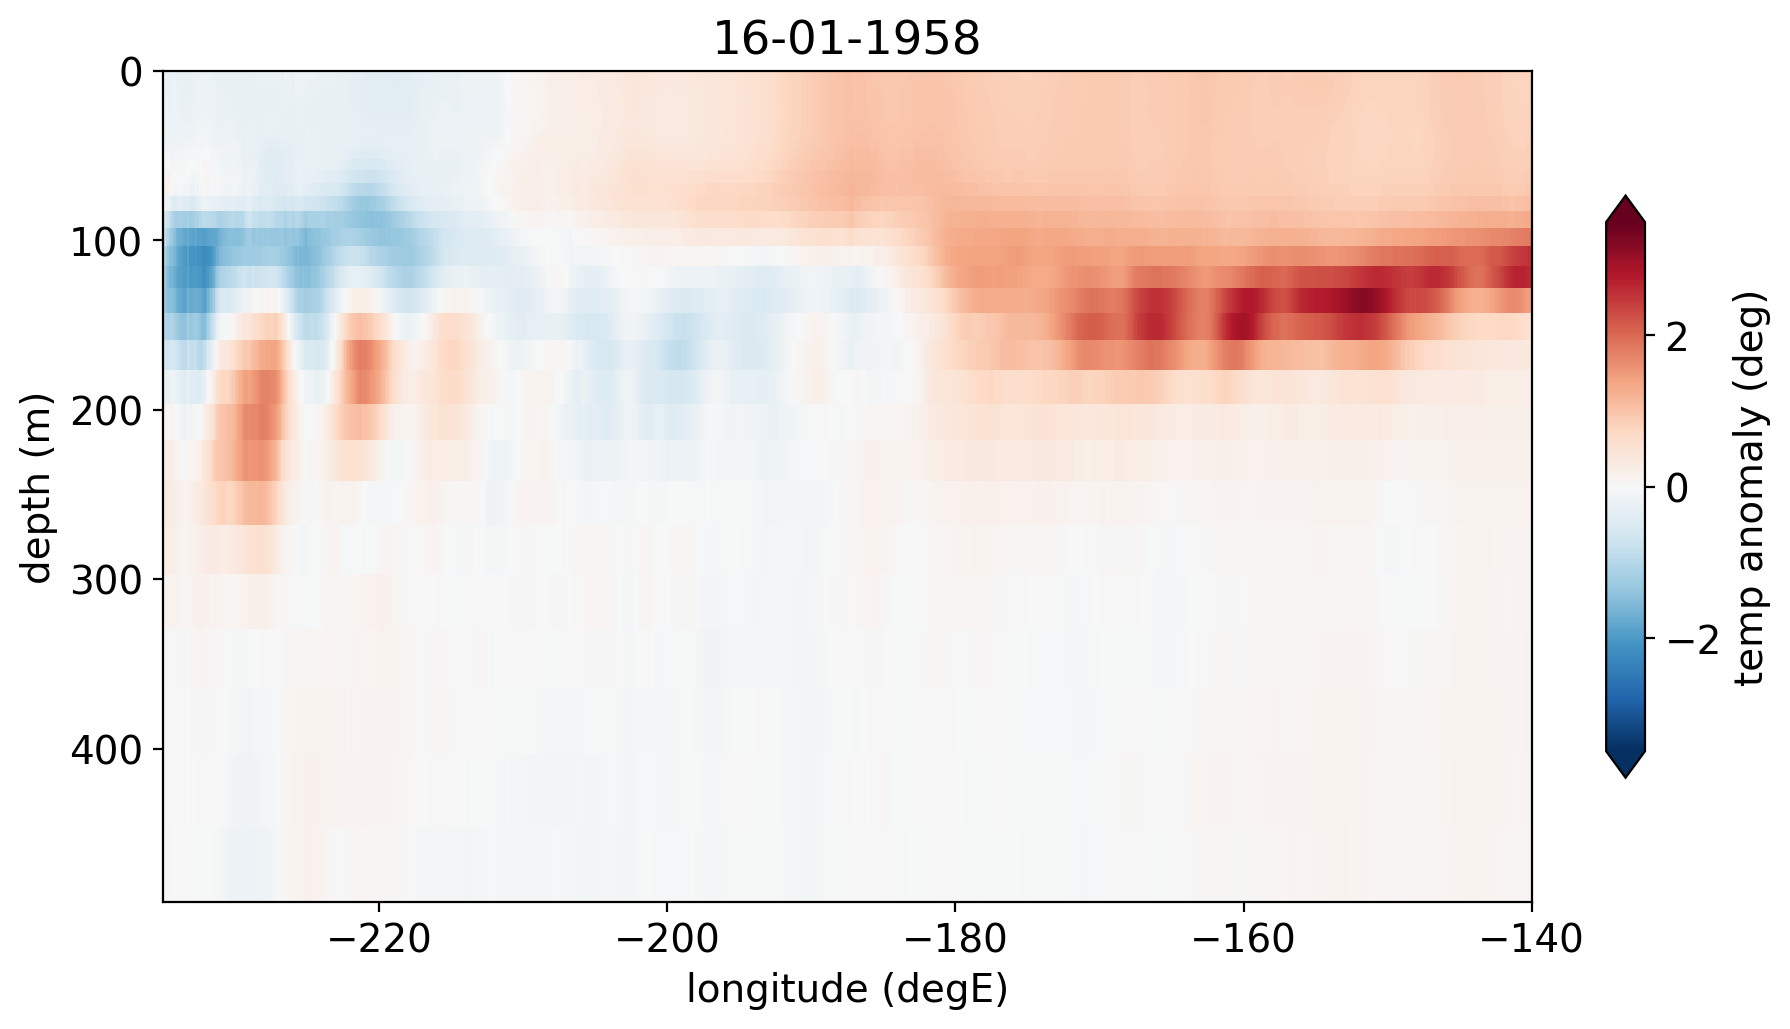

In [18]:
mov.preview(0)

In [19]:
mov.save(filename + ".mp4",
         progress=True,
         framerate=3,
         overwrite_existing=True,
         remove_movie=False,
         parallel=True,
         parallel_compute_kwargs=dict(scheduler="processes", num_workers=12)
        )

  warnings.warn(



Movie created at temp_anomaly-0p10.mp4
